In [124]:
import pandas as pd
import joblib
import numpy as np
from pprint import pprint
import os
import glob
import seaborn as sns
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
def laod_pickle(file_name, default_dir ="/home/xiaolan/project/private/contest/restaurant_visitor_forecasting/resources/cache"):    
    out = joblib.load(os.path.join(default_dir, file_name))
    pprint(out.head(5))
    print("\n{} is of shape: {}".format(file_name, out.shape))
    return out

In [189]:
air_store = laod_pickle("air_store.p")

           air_store_id  air_genre_name                 air_area_name  \
0  air_0f0cdeee6c9bf3d7  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri   
1  air_7cc17a324ae5c7dc  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri   
2  air_fee8dcf4d619598e  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri   
3  air_a17f0778617c76e2  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri   
4  air_83db5aff8f50478e  Italian/French  Tōkyō-to Minato-ku Shibakōen   

    latitude   longitude  
0  34.695124  135.197852  
1  34.695124  135.197852  
2  34.695124  135.197852  
3  34.695124  135.197852  
4  35.658068  139.751599  

air_store.p is of shape: (829, 5)


In [107]:
date_info = laod_pickle("date_info.p")

  calendar_date day_of_week  holiday_flg  calendar_year  calendar_month  \
0    2016-01-01      Friday            1           2016               1   
1    2016-01-02    Saturday            1           2016               1   
2    2016-01-03      Sunday            1           2016               1   
3    2016-01-04      Monday            0           2016               1   
4    2016-01-05     Tuesday            0           2016               1   

   calendar_day  calendar_dow  
0             1             4  
1             2             5  
2             3             6  
3             4             0  
4             5             1  

date_info.p is of shape: (517, 7)


In [37]:
air_visit = laod_pickle("air_visit.p")

           air_store_id visit_date  visitors
0  air_ba937bf13d40fb24 2016-01-13        25
1  air_ba937bf13d40fb24 2016-01-14        32
2  air_ba937bf13d40fb24 2016-01-15        29
3  air_ba937bf13d40fb24 2016-01-16        22
4  air_ba937bf13d40fb24 2016-01-18         6

air_visit.p is of shape: (252108, 3)


In [46]:
air_visit['visit_month'] = air_visit.visit_date.dt.month

In [139]:
eof_train = datetime.strptime("2017-03-14", "%Y-%m-%d")

In [141]:
air_visit['is_eval'] = air_visit['visit_date'] >= eof_train

In [142]:
air_visit['is_eval'].sum()

28759

In [93]:
air_visit.head()

,air_store_id,visit_date,visitors,visit_month,quarter
0,air_ba937bf13d40fb24,2016-01-13,25,1,0.0
1,air_ba937bf13d40fb24,2016-01-14,32,1,0.0
2,air_ba937bf13d40fb24,2016-01-15,29,1,0.0
3,air_ba937bf13d40fb24,2016-01-16,22,1,0.0
4,air_ba937bf13d40fb24,2016-01-18,6,1,0.0


In [143]:
# quarter by temperature
quarter_map = dict(zip( [i for i in range(12)], [ int(i/3)  for i in range(0, 12)]))
air_visit["quarter"] = air_visit.visit_month.map(quarter_map)

In [144]:
capacity = pd.merge(air_visit.groupby(["air_store_id","quarter"]).apply(lambda x: pd.Series({
    "visitors": x.visitors.max()
})).reset_index(), air_visit, on = ['air_store_id', 'quarter','visitors'])

In [229]:
capacity["dow"] = capacity.visit_date.dt.dayofweek

In [171]:
capacity.sort_values(['air_store_id','visitors'], ascending=False).groupby(['air_store_id']).first().visit_month.value_counts()

3     154
7     103
1      94
2      86
4      85
10     74
11     72
9      60
8      46
5      32
6      23
Name: visit_month, dtype: int64

In [204]:
capacity.head()

,air_store_id,quarter,visitors,visit_date,visit_month,is_eval
0,air_00a91d42b08b08d9,0.0,52,2017-02-15,2,False
1,air_00a91d42b08b08d9,1.0,55,2017-04-21,4,True
2,air_00a91d42b08b08d9,2.0,53,2016-07-22,7,False
3,air_00a91d42b08b08d9,3.0,57,2016-10-14,10,False
4,air_0164b9927d20bcc3,0.0,27,2017-01-11,1,False


In [177]:
max_visit_day = capacity.sort_values(['air_store_id','visitors'], ascending=False).groupby(['air_store_id']).first().visit_date.value_counts().reset_index().rename(columns ={"index":"calendar_date", "visit_date":"num_restaurant"})

In [178]:
max_visit_day = pd.merge(max_visit_day, date_info, on = "calendar_date", how="left")

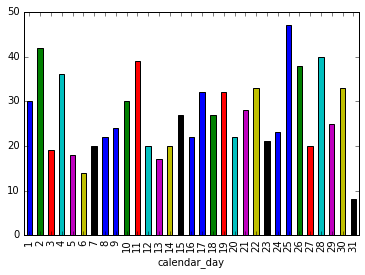

In [180]:
max_visit_day.groupby("calendar_day").num_restaurant.sum().plot(kind="bar")

In [154]:
max_capacity = pd.merge(air_visit.groupby(["air_store_id"])['visitors'].apply(np.max).reset_index(),
                         air_visit.loc[air_visit.is_eval == False,:].groupby(["air_store_id"])['visitors'].apply(np.max).reset_index(),
                         on="air_store_id",suffixes=('_leak', '_noleak'))

In [212]:
suspicious_list  = max_capacity.loc[(max_capacity.visitors_leak - max_capacity.visitors_noleak)/max_capacity.visitors_noleak > 0.5,"air_store_id"].tolist()

In [239]:
max_capacity.loc[(max_capacity.visitors_leak - max_capacity.visitors_noleak)/max_capacity.visitors_noleak > 0.3,]

,air_store_id,visitors_leak,visitors_noleak
44,air_0f60e1576a7d397d,65,38
164,air_382f5ace4e2247b8,63,42
192,air_40953e2d8b4f2857,58,42
244,air_51281cd059d7b89b,262,33
323,air_68147db09287bf74,64,39
367,air_7420042ff75f9aca,67,44
372,air_754ae581ad80cc9f,59,44
379,air_789103bf53b8096b,95,11
391,air_7cf5a02c0e01b647,90,60
402,air_8110d68cc869b85e,124,60


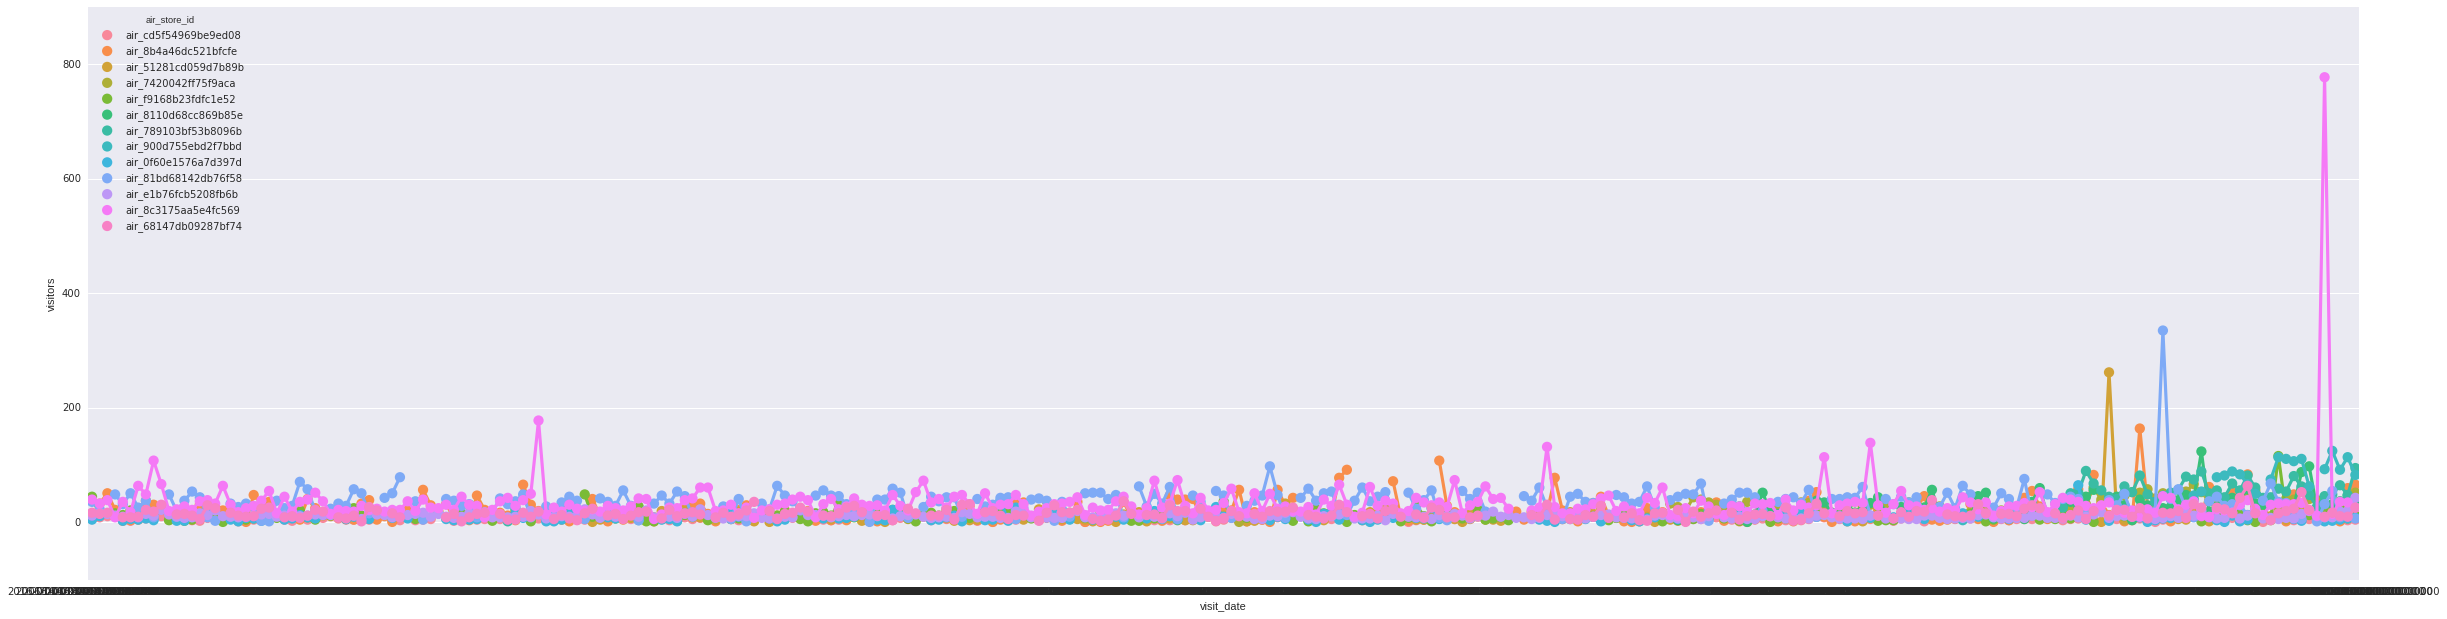

In [224]:
sns.set(rc={'figure.figsize':(40.7,10.27)})
sns.pointplot(x="visit_date", y="visitors", hue="air_store_id",data=air_visit.loc[air_visit.air_store_id.isin(suspicious_list),], dodge=False)

air_store_id
air_81bd68142db76f58    Axes(0.125,0.2;0.775x0.7)
dtype: object

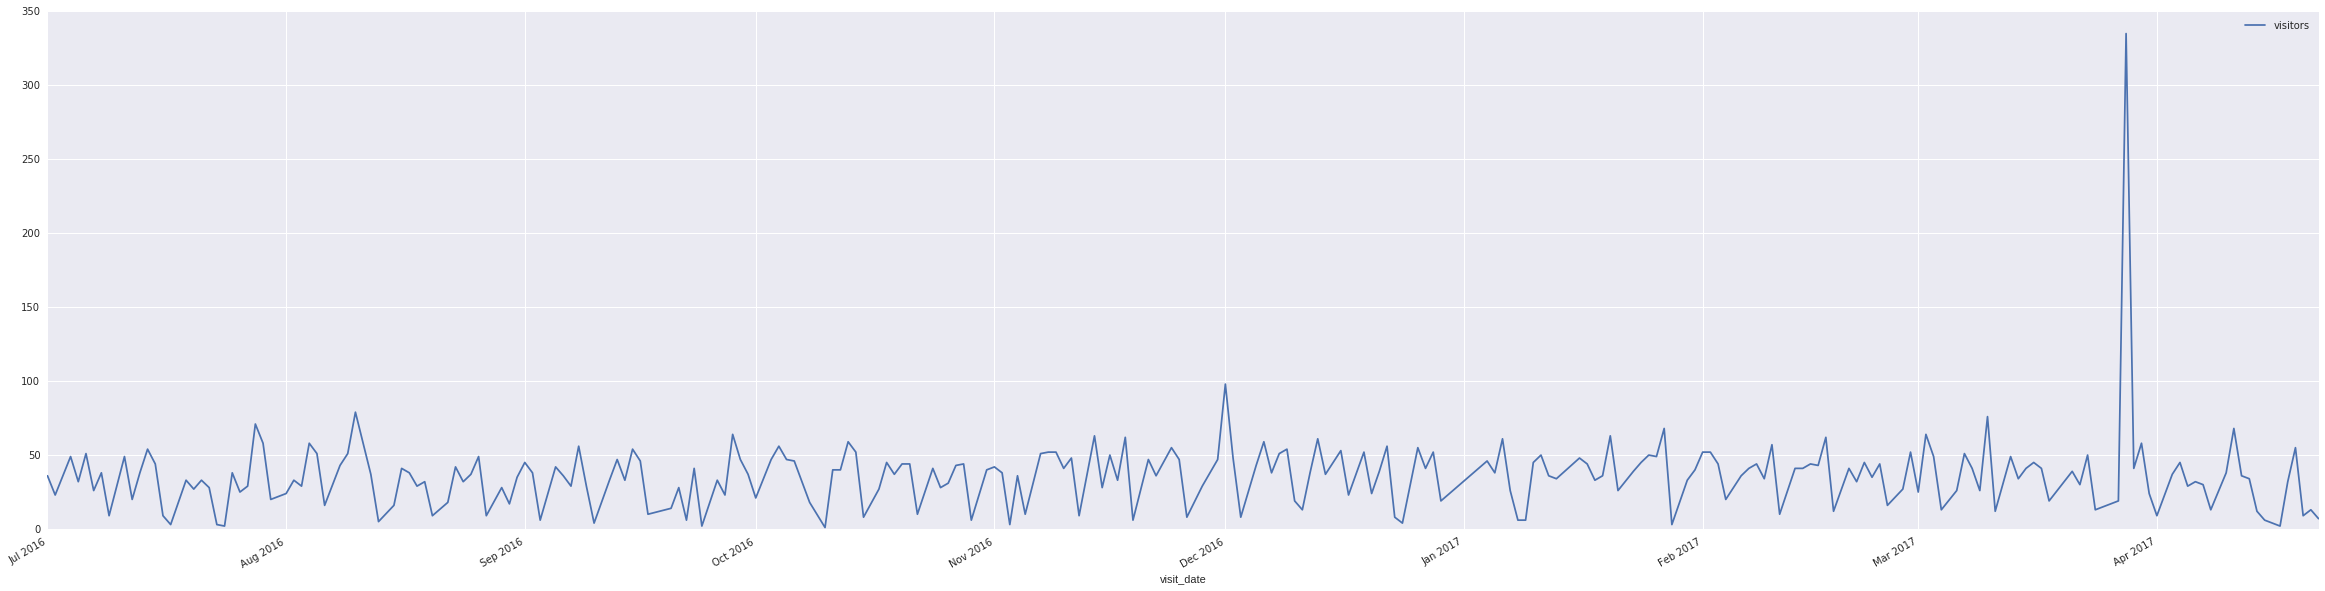

In [227]:
air_visit.loc[air_visit.air_store_id.isin(["air_81bd68142db76f58"]),].groupby("air_store_id").plot(x = "visit_date", y="visitors", kind="line")

In [230]:
capacity[capacity.air_store_id == "air_81bd68142db76f58"]

,air_store_id,quarter,visitors,visit_date,visit_month,is_eval,dow
1794,air_81bd68142db76f58,0.0,68,2017-01-27,1,False,4
1795,air_81bd68142db76f58,1.0,335,2017-03-28,3,True,1
1796,air_81bd68142db76f58,2.0,79,2016-08-10,8,False,2
1797,air_81bd68142db76f58,3.0,64,2016-09-28,9,False,2


air_store_id
air_51281cd059d7b89b    Axes(0.125,0.2;0.775x0.7)
dtype: object

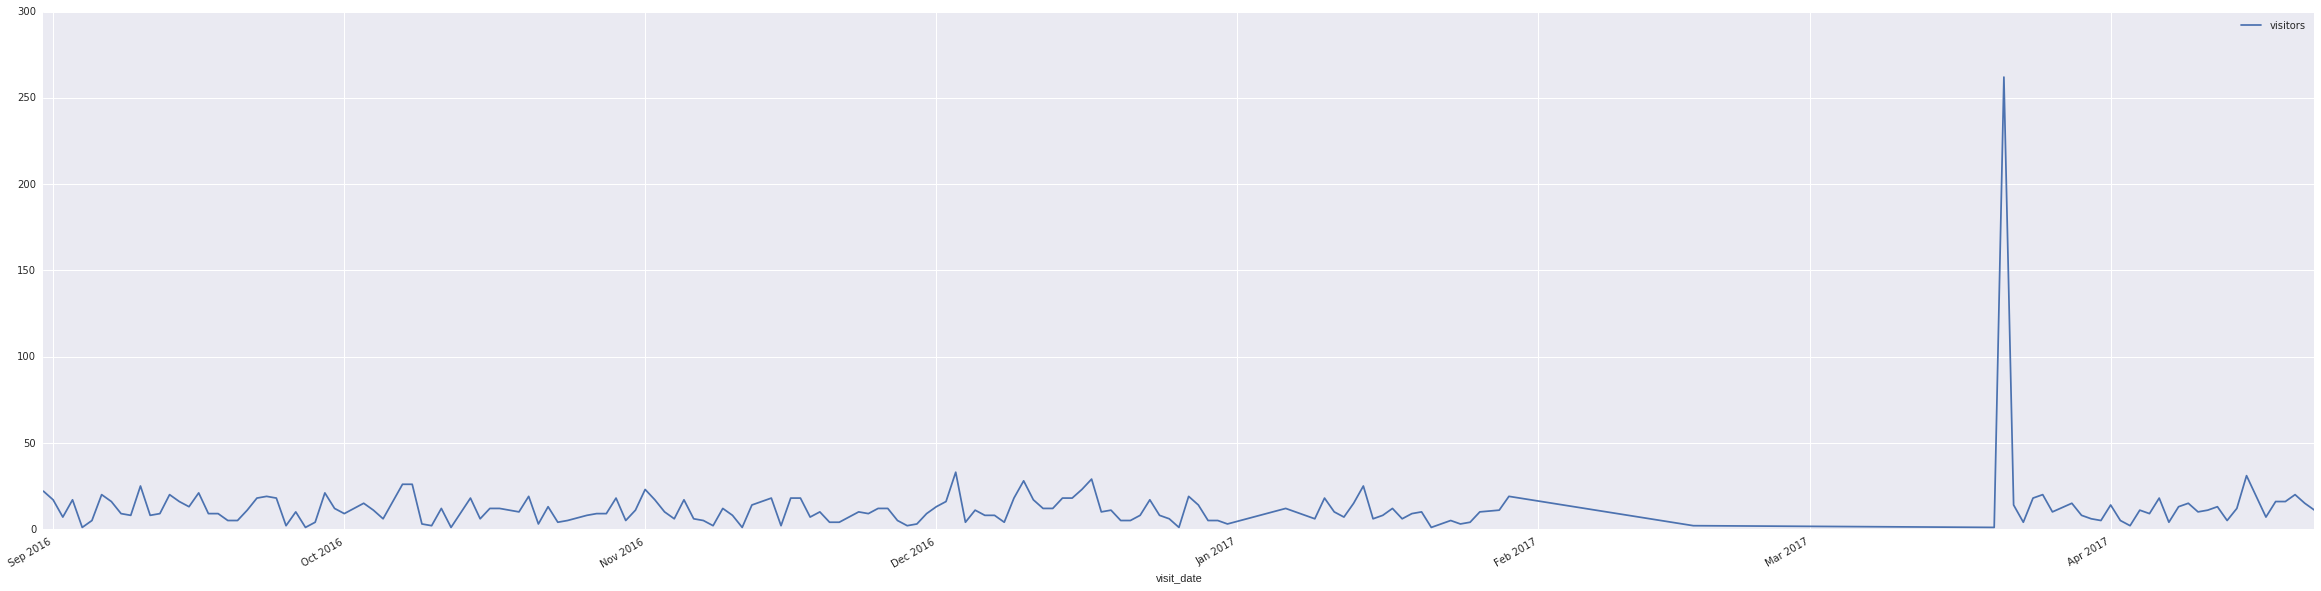

In [231]:
air_visit.loc[air_visit.air_store_id.isin(["air_51281cd059d7b89b"]),].groupby("air_store_id").plot(x = "visit_date", y="visitors", kind="line")

In [232]:
capacity[capacity.air_store_id == "air_51281cd059d7b89b"]

,air_store_id,quarter,visitors,visit_date,visit_month,is_eval,dow
1089,air_51281cd059d7b89b,0.0,25,2017-01-14,1,False,5
1090,air_51281cd059d7b89b,1.0,262,2017-03-21,3,True,1
1091,air_51281cd059d7b89b,2.0,22,2016-08-31,8,False,2
1092,air_51281cd059d7b89b,3.0,26,2016-10-07,10,False,4
1093,air_51281cd059d7b89b,3.0,26,2016-10-08,10,False,5


air_store_id
air_8b4a46dc521bfcfe    Axes(0.125,0.2;0.775x0.7)
dtype: object

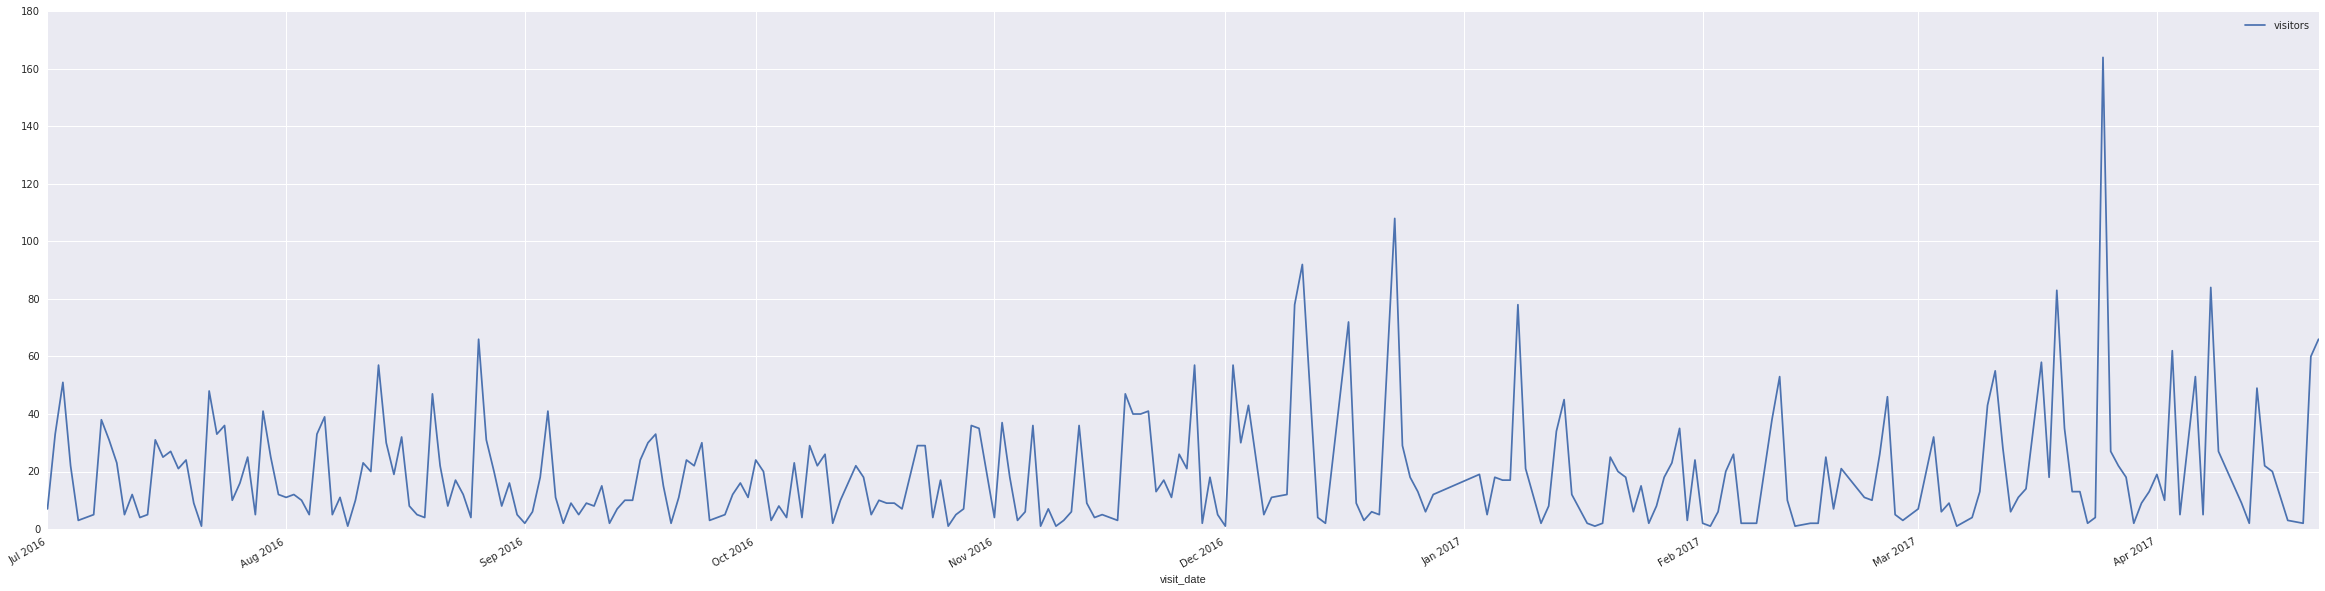

In [234]:
air_visit.loc[air_visit.air_store_id.isin(["air_8b4a46dc521bfcfe"]),].groupby("air_store_id").plot(x = "visit_date", y="visitors", kind="line")

air_store_id
air_900d755ebd2f7bbd    Axes(0.125,0.2;0.775x0.7)
dtype: object

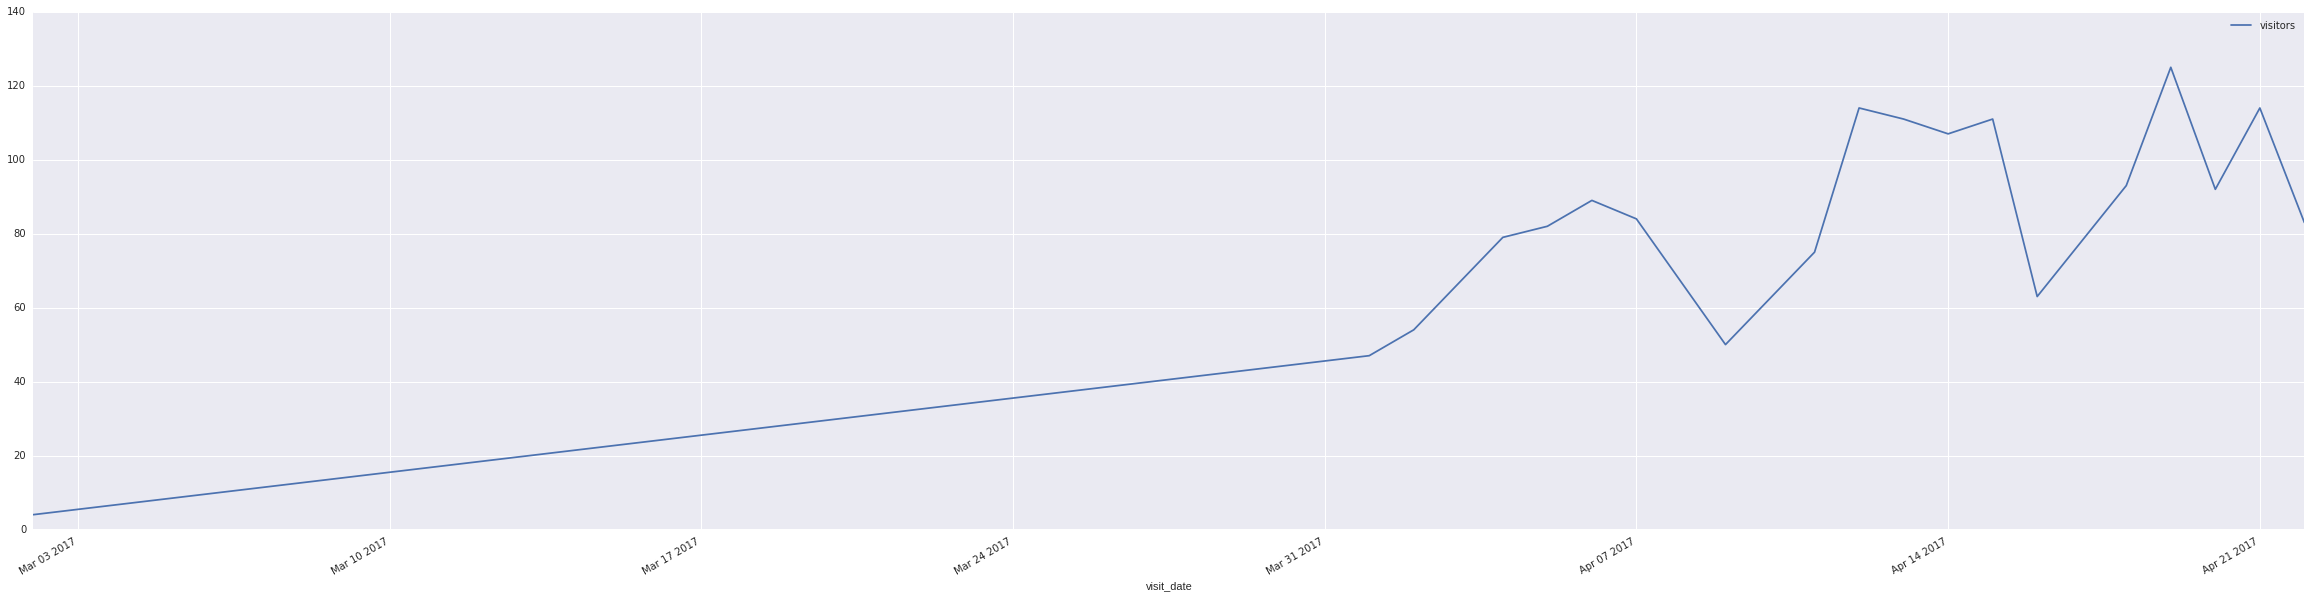

In [236]:
air_visit.loc[air_visit.air_store_id.isin(["air_900d755ebd2f7bbd"]),].\
groupby("air_store_id").plot(x = "visit_date", y="visitors", kind="line")

In [235]:
capacity[capacity.air_store_id == "air_900d755ebd2f7bbd"]

,air_store_id,quarter,visitors,visit_date,visit_month,is_eval,dow
1998,air_900d755ebd2f7bbd,1.0,125,2017-04-19,4,True,2


air_store_id
air_81bd68142db76f58    Axes(0.125,0.2;0.775x0.7)
dtype: object

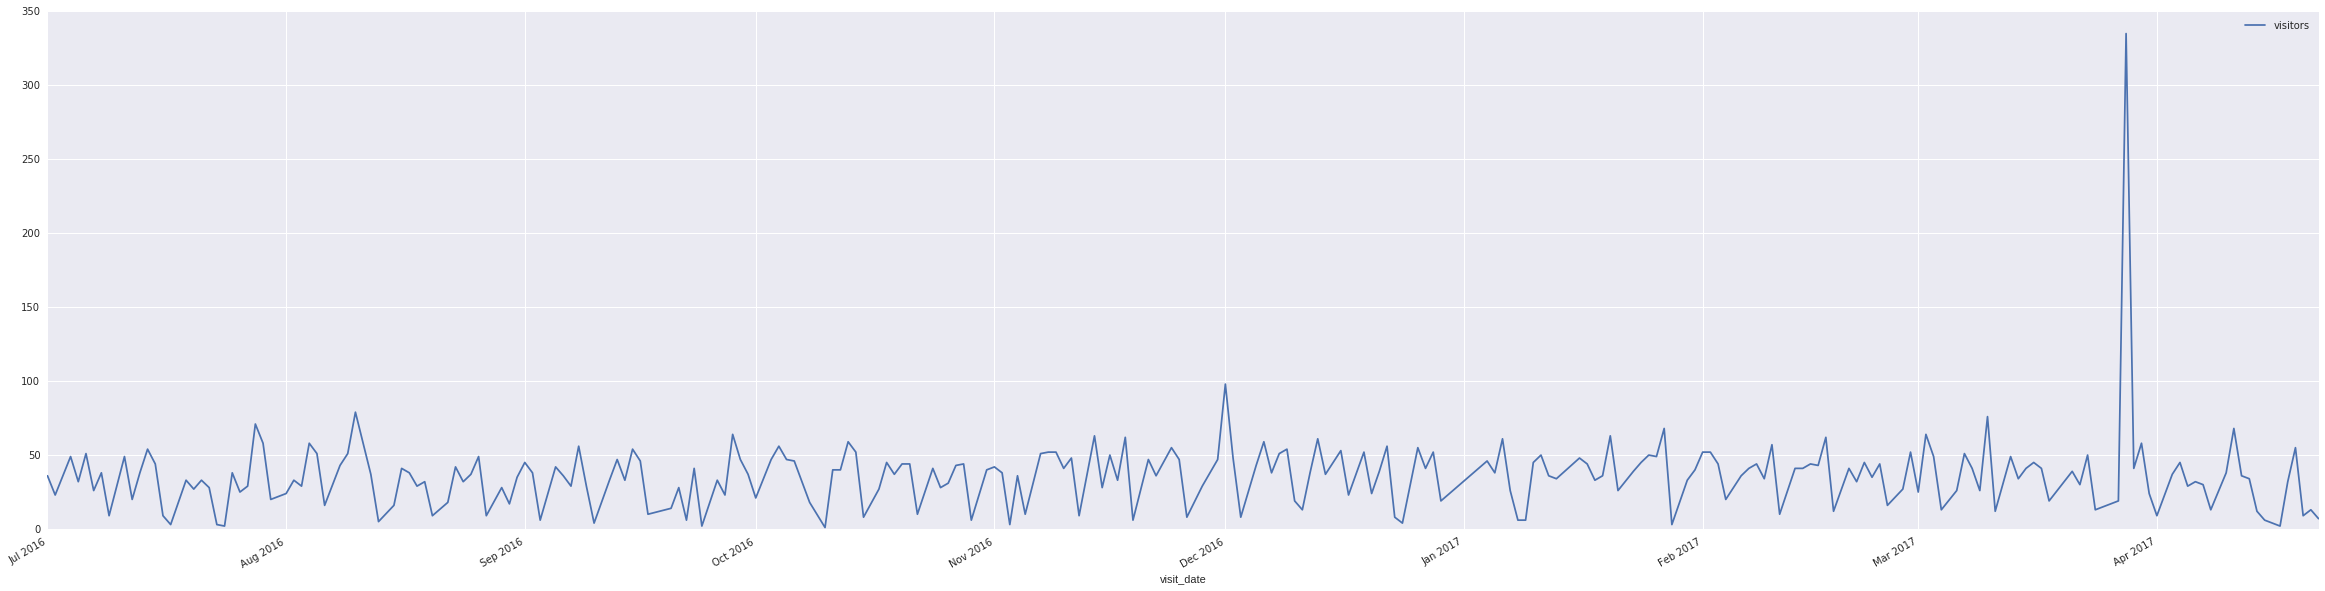

In [241]:
air_visit.loc[air_visit.air_store_id.isin(["air_81bd68142db76f58"]),].\
groupby("air_store_id").plot(x = "visit_date", y="visitors", kind="line")

In [254]:
air_visit.loc[air_visit.air_store_id == "air_81bd68142db76f58",]["visitors"].quantile(0.995)

93.53499999999974

In [240]:
capacity[capacity.air_store_id == "air_81bd68142db76f58"]

,air_store_id,quarter,visitors,visit_date,visit_month,is_eval,dow
1794,air_81bd68142db76f58,0.0,68,2017-01-27,1,False,4
1795,air_81bd68142db76f58,1.0,335,2017-03-28,3,True,1
1796,air_81bd68142db76f58,2.0,79,2016-08-10,8,False,2
1797,air_81bd68142db76f58,3.0,64,2016-09-28,9,False,2


air_store_id
air_8110d68cc869b85e    Axes(0.125,0.2;0.775x0.7)
dtype: object

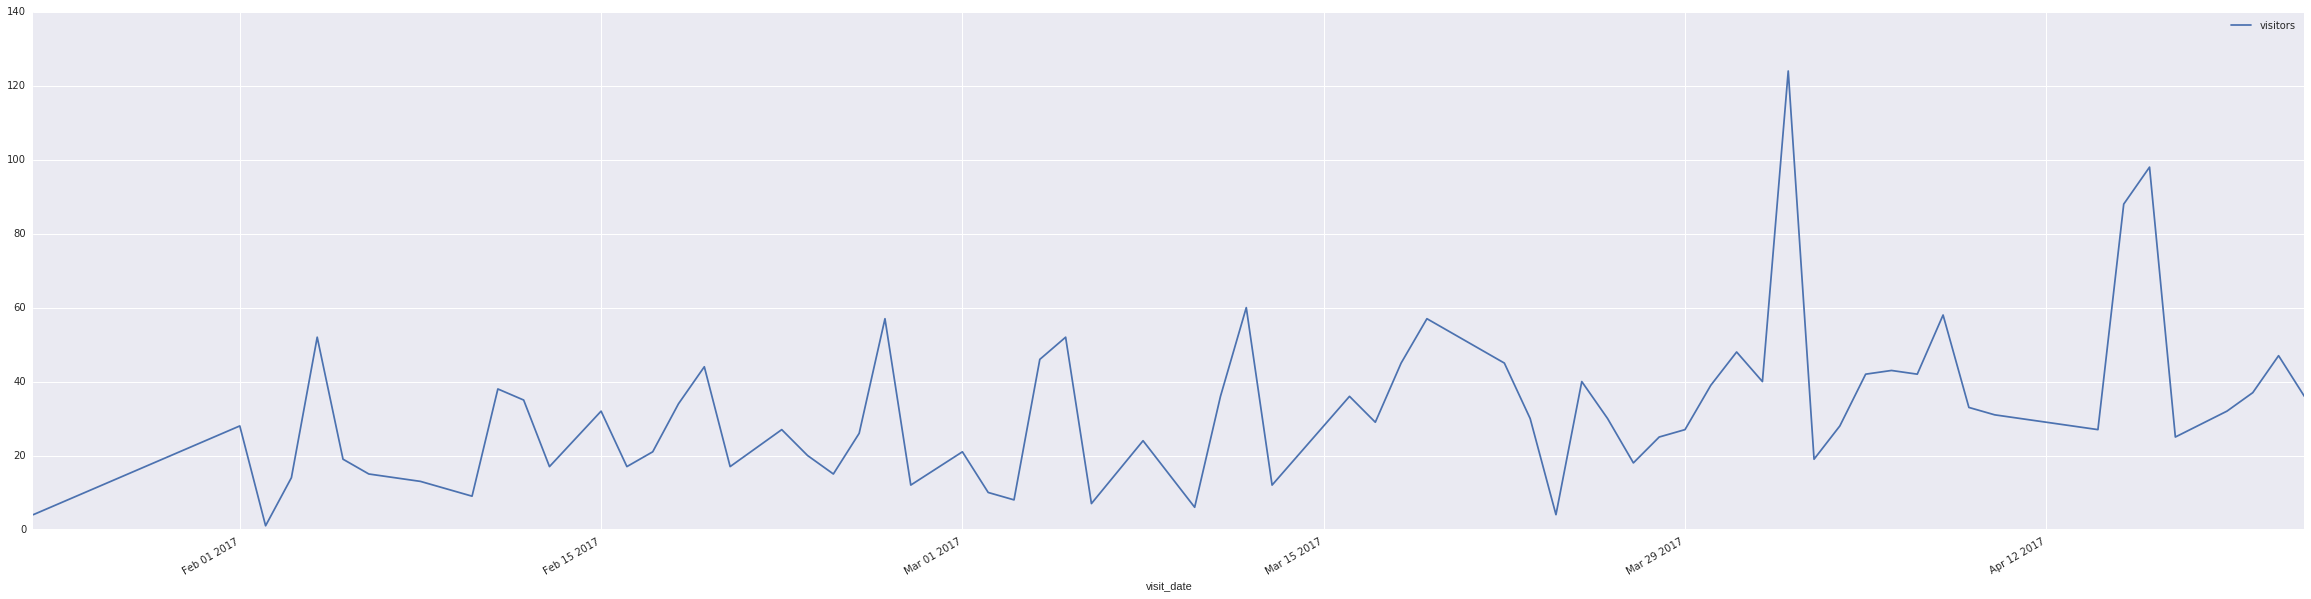

In [238]:
air_visit.loc[air_visit.air_store_id.isin(["air_8110d68cc869b85e"]),].\
groupby("air_store_id").plot(x = "visit_date", y="visitors", kind="line")

In [237]:
capacity[capacity.air_store_id == "air_8110d68cc869b85e"]

,air_store_id,quarter,visitors,visit_date,visit_month,is_eval,dow
1782,air_8110d68cc869b85e,0.0,57,2017-02-26,2,False,6
1783,air_8110d68cc869b85e,1.0,124,2017-04-02,4,True,6


In [256]:
capacity[capacity.air_store_id == "air_8b4a46dc521bfcfe"]

,air_store_id,quarter,visitors,visit_date,visit_month,is_eval,dow
1939,air_8b4a46dc521bfcfe,0.0,78,2017-01-08,1,False,6
1940,air_8b4a46dc521bfcfe,1.0,164,2017-03-25,3,True,5
1941,air_8b4a46dc521bfcfe,2.0,66,2016-08-26,8,False,4
1942,air_8b4a46dc521bfcfe,3.0,57,2016-11-27,11,False,6


Restaurate max capacity see an surge, undergoing renovation?

In [217]:
tmp = capacity.sort_values(['air_store_id', "visitors"], ascending=False).groupby("air_store_id").first().reset_index()

In [218]:
tmp.head()

,air_store_id,quarter,visitors,visit_date,visit_month,is_eval
0,air_00a91d42b08b08d9,3.0,57,2016-10-14,10,False
1,air_0164b9927d20bcc3,0.0,27,2017-01-11,1,False
2,air_0241aa3964b7f861,0.0,37,2016-02-27,2,False
3,air_0328696196e46f18,0.0,41,2017-02-12,2,False
4,air_034a3d5b40d5b1b1,3.0,116,2016-11-30,11,False


In [219]:
pd.merge(air_store.loc[air_store.air_store_id.isin(suspicious_list)], tmp,  on="air_store_id")

,air_store_id,air_genre_name,air_area_name,latitude,longitude,quarter,visitors,visit_date,visit_month,is_eval
0,air_900d755ebd2f7bbd,Italian/French,Tōkyō-to Chūō-ku Ginza,35.672114,139.770825,1.0,125,2017-04-19,4,True
1,air_68147db09287bf74,Dining bar,Tōkyō-to Setagaya-ku Setagaya,35.646572,139.653247,1.0,64,2017-04-08,4,True
2,air_8b4a46dc521bfcfe,Dining bar,Hokkaidō Asahikawa-shi 6 Jōdōri,43.770635,142.364819,1.0,164,2017-03-25,3,True
3,air_e1b76fcb5208fb6b,Dining bar,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,1.0,43,2017-04-22,4,True
4,air_cd5f54969be9ed08,Dining bar,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,1.0,25,2017-04-12,4,True
5,air_0f60e1576a7d397d,Cafe/Sweets,Fukuoka-ken Itoshima-shi Maebarunishi,33.557320,130.195555,1.0,65,2017-03-17,3,True
6,air_51281cd059d7b89b,Izakaya,Shizuoka-ken Hamamatsu-shi Motoshirochō,34.710895,137.725940,1.0,262,2017-03-21,3,True
7,air_789103bf53b8096b,Izakaya,Tōkyō-to Ōta-ku Kamiikedai,35.602201,139.697689,1.0,95,2017-04-22,4,True
8,air_8110d68cc869b85e,Izakaya,Tōkyō-to Taitō-ku Asakusa,35.711877,139.796697,1.0,124,2017-04-02,4,True
9,air_81bd68142db76f58,Izakaya,Tōkyō-to Taitō-ku Asakusa,35.711877,139.796697,1.0,335,2017-03-28,3,True


In [255]:
#wrong_input
# air_store_id, visit_date, visitors
correction = [("air_8c3175aa5e4fc569", "2017-04-18", 177),
             ("air_51281cd059d7b89b", "2017-03-21", 26),
              ("air_81bd68142db76f58", "2017-03-28", 35)
             ]

In [265]:
for rid, d, n in correction:
    air_visit.loc[ (air_visit["air_store_id"] == rid) & (air_visit["visit_date"] == d),"visitors"] = n

,air_store_id,visit_date,visitors,visit_month,quarter,is_eval
0,air_ba937bf13d40fb24,2016-01-13,25,1,0.0,False
1,air_ba937bf13d40fb24,2016-01-14,32,1,0.0,False
2,air_ba937bf13d40fb24,2016-01-15,29,1,0.0,False
3,air_ba937bf13d40fb24,2016-01-16,22,1,0.0,False
4,air_ba937bf13d40fb24,2016-01-18,6,1,0.0,False


In [186]:
appear_day = air_visit.groupby("air_store_id").apply(lambda x: pd.Series({  
    "operating_day": x.shape[0],
    "first_appear": x.visit_date.min()
})).reset_index()